### Importing Libraries

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
from datetime import datetime, timedelta
from functools import partial
from imblearn.over_sampling import SMOTE
from math import exp, log10, sqrt
from pyswarm import pso
from scipy.optimize import curve_fit
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, r2_score, matthews_corrcoef, mean_squared_error, 
                             median_absolute_error, explained_variance_score, mean_absolute_error)
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR


### Loading Dataset

United States Geological Survey (USGS) earthquake catalogs were downloaded for the period: January 1980 to February 2023.
<br>Link: https://earthquake.usgs.gov/earthquakes/search/

In [2]:
earthquakes_chile = pd.read_csv('earthquake_data_chile.csv')

earthquakes_chile.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,1980-01-05T14:12:10.200Z,-23.975,-66.463,172.0,4.5,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:24:14.917Z,"30 km NNW of San Antonio de los Cobres, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
1,1980-01-06T11:38:59.700Z,-34.397,-72.248,33.0,4.5,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:24:15.275Z,"85 km WNW of Santa Cruz, Chile",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
2,1980-01-08T11:04:23.900Z,-24.619,-70.878,33.0,4.3,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:24:15.670Z,"95 km NNW of Taltal, Chile",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
3,1980-01-08T19:20:32.300Z,-20.920,-69.192,105.0,4.8,mb,NaN,NaN,NaN,NaN,...,2014-11-06T23:24:15.688Z,"126 km SE of Iquique, Chile",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us
4,1980-01-14T21:51:01.800Z,-33.194,-69.459,14.0,5.6,mb,NaN,NaN,NaN,NaN,...,2022-04-28T01:48:03.336Z,"67 km WSW of Mendoza, Argentina",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


### Exploratory Data Analysis

In [3]:
# Understanding the data spreadout

# Define ranges for the magnitudes
ranges = [(1, 1.9), (2, 2.9), (3, 3.9), (4, 4.9), (5, 5.9), (6, 6.9), (7, 7.9), (8, 8.9), (9, 9.9)]

# Count the occurrences within each range
counts = {}

for start, end in ranges:
    count = earthquakes_chile[(earthquakes_chile['mag'] >= start) & (earthquakes_chile['mag'] < end + 0.1)].shape[0]
    counts[f"{start}-{end}"] = count
    
# Print the results
for range_str, count in counts.items():
    print(f"Count of mag in range {range_str}: {count}")

Count of mag in range 1-1.9: 223
Count of mag in range 2-2.9: 6162
Count of mag in range 3-3.9: 15125
Count of mag in range 4-4.9: 18100
Count of mag in range 5-5.9: 2604
Count of mag in range 6-6.9: 261
Count of mag in range 7-7.9: 23
Count of mag in range 8-8.9: 5
Count of mag in range 9-9.9: 0


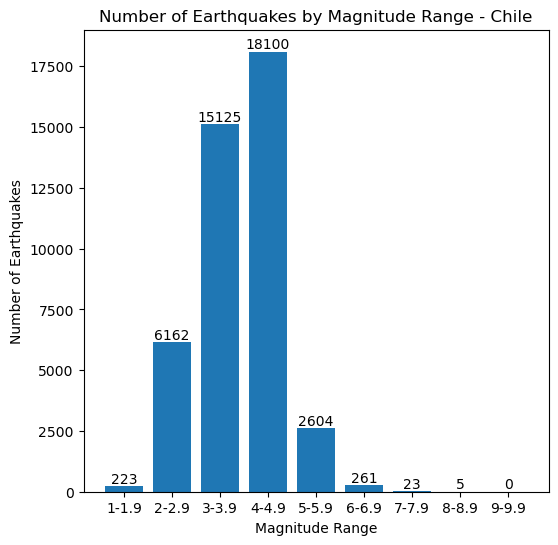

In [4]:
# Prepare data for plotting
mag_ranges = list(counts.keys())
num_earthquakes = list(counts.values())

# Create the bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(mag_ranges, num_earthquakes)
plt.xlabel('Magnitude Range')
plt.ylabel('Number of Earthquakes')
plt.title('Number of Earthquakes by Magnitude Range - Chile')

# Annotate the bars
for bar in bars:
    height = bar.get_height()
    plt.gca().text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), ha='center', va='bottom')

# Display the plot
plt.show()


In [5]:
earthquakes_chile.dtypes

time                object
latitude           float64
longitude          float64
depth              float64
mag                float64
magType             object
nst                float64
gap                float64
dmin               float64
rms                float64
net                 object
id                  object
updated             object
place               object
type                object
horizontalError    float64
depthError         float64
magError           float64
magNst             float64
status              object
locationSource      object
magSource           object
dtype: object

In [6]:
# Converting column 'time' to datetime datatype
earthquakes_chile['time'] = pd.to_datetime(earthquakes_chile['time'])

In [7]:
earthquakes_chile.dtypes

time               datetime64[ns, UTC]
latitude                       float64
longitude                      float64
depth                          float64
mag                            float64
magType                         object
nst                            float64
gap                            float64
dmin                           float64
rms                            float64
net                             object
id                              object
updated                         object
place                           object
type                            object
horizontalError                float64
depthError                     float64
magError                       float64
magNst                         float64
status                          object
locationSource                  object
magSource                       object
dtype: object

In [8]:
earthquakes_chile.isnull().sum()

time                   0
latitude               0
longitude              0
depth                  0
mag                    0
magType                0
nst                21637
gap                20742
dmin               36148
rms                20066
net                    0
id                     0
updated                0
place                  2
type                   0
horizontalError    36373
depthError         29420
magError           36039
magNst             26319
status                 0
locationSource         0
magSource              0
dtype: int64

In [9]:
#Dropping unwanted columns
earthquakes_chile = earthquakes_chile.drop(['nst','gap', 'rms','horizontalError','depthError','dmin', 'magError', 'magNst','magType','net','id','updated','place','status','locationSource','magSource','type'], axis=1)

In [10]:
earthquakes_chile.isnull().sum()

time         0
latitude     0
longitude    0
depth        0
mag          0
dtype: int64

In [11]:
earthquakes_chile.shape

(42503, 5)

### Calculating the Cut-off magnitudes

<p>Cut-off magnitude corresponds to the earthquake magnitude in the catalog above which catalog is complete and no seismic event is missing. This depends upon the level of instrumentation. Dense instrumentation in a region leads to better completeness of catalog with low cut-off magnitude. The cut-off magnitude for Chile is found to be around 4.25.
<br>
Cut-off magnitudes are computed using the Gutenberg-Richter law (the point where curve deviates from exponential behavior is selected as a cut-off magnitude).
Before using the data for the parameter computation, all the occurrences reported below the cut-off magnitude are discarded.</p>
    

Cut-off magnitude: 4.25


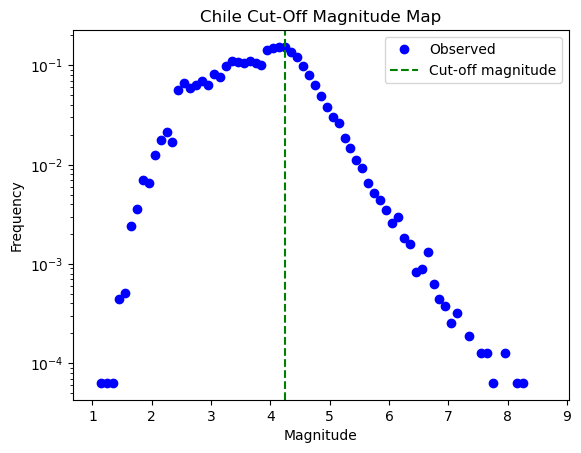

In [12]:
start_time = "1980-01-01"
end_time = "2023-02-28"
min_magnitude = 1.0

# Convert start_time and end_time to datetime objects
start_time = datetime.strptime(start_time, '%Y-%m-%d')
end_time = datetime.strptime(end_time, '%Y-%m-%d')

# Calculate the duration between start_time and end_time
duration = end_time - start_time

# Compute the frequency-magnitude distribution
magnitude_bins = np.arange(min_magnitude, earthquakes_chile["mag"].max(), 0.1)
hist, edges = np.histogram(earthquakes_chile["mag"], bins=magnitude_bins)
hist = hist / duration.days
magnitudes = (edges[1:] + edges[:-1]) / 2

# Fit the Gutenberg-Richter law to the data
def gutenberg_richter(magnitude, a, b):
    return 10 ** (a - b * magnitude)


popt, pcov = curve_fit(gutenberg_richter, magnitudes, hist)

# Determine the point of deviation
residuals = np.abs(hist - gutenberg_richter(magnitudes, *popt))
cutoff_magnitude_chile = magnitudes[np.argmax(residuals)]

print("Cut-off magnitude:", round(cutoff_magnitude_chile, 3))

# Plot the results
plt.plot(magnitudes, hist, "bo", label="Observed")
plt.axvline(cutoff_magnitude_chile, color="g", linestyle="--", label="Cut-off magnitude")
plt.title("Chile Cut-Off Magnitude Map")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.yscale("log")
plt.legend()
plt.show()


In [13]:
# Removing the data below the cut-off magnitudes
earthquakes_chile_cutoff = earthquakes_chile[earthquakes_chile['mag'] >= cutoff_magnitude_chile]


print("Chile Data Dimensions: ", earthquakes_chile.shape)

print("\nChile Cut-off Data Dimensions: ", earthquakes_chile_cutoff.shape)

Chile Data Dimensions:  (42503, 5)

Chile Cut-off Data Dimensions:  (13971, 5)


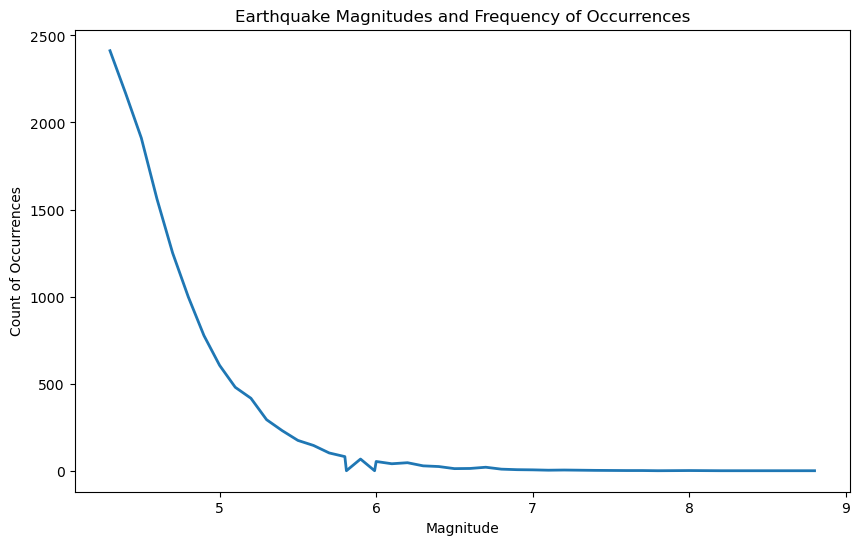

In [14]:
# Calculate the frequency of occurrences for different magnitudes
magnitude_counts = earthquakes_chile_cutoff['mag'].value_counts().sort_index().reset_index()
magnitude_counts.columns = ['magnitude', 'count']

plt.figure(figsize=(10, 6))

# Plot the curve using a line without dots
plt.plot(magnitude_counts['magnitude'], magnitude_counts['count'], linestyle='-', linewidth=2)

plt.xlabel('Magnitude')
plt.ylabel('Count of Occurrences')
plt.title('Earthquake Magnitudes and Frequency of Occurrences')
plt.show()


### Feature Calculation

<p style="font-size: larger;">Feature Calculation entails converting raw data into representative and meaningful features that algorithms can use in detecting patterns, trends, and relationships. Good quality and effective relevance of these features significantly affect the model performance. Moreover, focusing on the vital information present in the data through feature calculations enhances model performance.</p>

<p style="font-size: larger;">By leveraging domain-specific knowledge, meaningful features can be created leading to improved model effectiveness. In this case, the understanding of seismic activity such as <strong>Seismic Energy Release</strong>, <strong>Mean Magnitude</strong>, <strong>Seismic Rate Changes</strong>, <strong>Maximum Magnitude</strong> observed during the days leading to a major event, <strong>Deviation from Gutenberg Richter Law</strong>, <strong>Deficit between the actual and the expected magnitudes</strong>, etc. was the key. Seismic parameters that are derived analytically are essentially intended to describe the internal geological state of the ground prior to earthquake occurrence.</p>


In [15]:
# Define the main dataframe
df = earthquakes_chile_cutoff

# Gutenberg-Richter function 
def gutenberg_richter(magnitudes):
    # Convert magnitudes to numpy array
    M = np.array(magnitudes)
    # Get the length of the magnitudes
    N = len(M)
    # Calculate b value according to the Gutenberg-Richter law
    b = (1 / (np.log(10) * N)) * np.sum(M - np.min(M) + 1)
    # Calculate a value according to the Gutenberg-Richter law
    a = np.log10(N) + b * np.min(M)
    return a, b

# Seismic energy release function
def seismic_energy_release(magnitudes, T, T_prev):
    # If T (the time period) is zero, call the function again with T replaced by T_prev
    if T == 0:
        return seismic_energy_release(magnitudes, T_prev, T_prev)

    # Convert magnitudes to numpy array
    M = np.array(magnitudes)
    # Calculate the total seismic energy released during the time period T
    E = np.sum(10 ** (11.8 + 1.5 * M))
    # Calculate the rate of seismic energy release
    dE = E / T
    # Calculate the square root of the rate of seismic energy release
    sqrt_dE = np.sqrt(dE)
    return sqrt_dE

# Function to calculate features from the dataframe
def calculate_features(df):
    features = []

    T_prev = None

    # Iterate over each row in the dataframe
    for index, row in df.iterrows():
        # For each row, select the last 50 rows before it that fall within 50 days of it
        df_n = df.loc[df['time'].between(row['time'] - pd.Timedelta(days=50), row['time'], inclusive='neither')].tail(50)

        # Check if there are enough rows in df_n
        if len(df_n) < 2:
            continue

        # Calculate the time period T as the difference in days between the first and the last row in df_n
        T = (df_n.iloc[-1]['time'] - df_n.iloc[0]['time']).days

        # If T is zero, and there is a previous T value, use that. Otherwise, skip this row.
        if T == 0:
            if T_prev is None:
                continue
            else:
                T = T_prev

        # Calculate a & b values based on the magnitudes in the dataset.
        magnitudes = df_n['mag'].values
        a, b = gutenberg_richter(magnitudes)

        # Calculate the square root of the rate of seismic energy release
        sqrt_dE = seismic_energy_release(magnitudes, T, T_prev)

        T_prev = T

        # Calculate the mean magnitude of the earthquakes
        Mmean = np.mean(magnitudes)

        # Calculate the maximum magnitude in the last 7 days, or use the magnitude of the current row if there is no data
        max_mag_7 = df_n[df_n['time'] >= (row['time'] - pd.Timedelta(days=7))]['mag'].max()
        if np.isnan(max_mag_7):
            max_mag_7 = row['mag']

        # Calculate the expected maximum magnitude
        M_max_exp = a / b
        # Calculate the difference between the actual and expected maximum magnitudes
        M_def = row['mag'] - M_max_exp

        # Calculate the residuals of the observed frequencies and those predicted by the Gutenberg–Richter law
        eta = sum([(log10(i+1) - a - b * M) ** 2 for i, M in enumerate(sorted(magnitudes, reverse=True))]) / (len(magnitudes) - 1)

        # Calculate the return period (expected average recurrence interval for earthquake events of a certain size)
        Tr = T / (10 ** (a - b * row['mag']))
        # Calculate the standard deviation of the b-values
        sigma_b = ((2.3 * (b ** 2)) * (np.sqrt(np.sum((magnitudes - Mmean) ** 2) / (len(magnitudes) * (len(magnitudes) - 1)))))
        # Calculate the proportion of earthquakes that have a magnitude above 6
        x_mag6 = exp((-3 * b) / log10(exp(1)))

        # Append all calculated features to the list
        features.append([row['time'], row['mag'], T, a, b, sqrt_dE, Mmean, max_mag_7, M_def, eta, Tr, sigma_b, x_mag6])

    # Create a new dataframe from the features list
    feature_columns = ['time', 'mag', 'T', 'a', 'b', 'sqrt_dE', 'Mmean', 'max_mag_7', 'M_def', 'eta', 'Tr', 'sigma_b', 'x_mag6']
    df_features = pd.DataFrame(features, columns=feature_columns)

    return df_features

# Use the function to calculate features from the main dataframe
df_final = calculate_features(df)


### Removing Irrelavant Features

In [16]:
# Irrelevant feature filter function
def irrel_filter(featSet, Target, L):
    # Initialize a zero vector for mutual information (MI) calculation
    MI = np.zeros(featSet.shape[1])
    # Define a small constant to avoid division by zero error in further computations
    epsilon = 1e-10  
    
    # Iterate over each feature
    for j in range(featSet.shape[1]):
        # Initialize count vectors
        U = np.zeros(2)   # Target variable count
        U1 = np.zeros(2)  # Count of instances where feature value is 0
        U2 = np.zeros(2)  # Count of instances where feature value is 1
        U3 = np.zeros(2)  # Count of instances where feature value is neither 0 nor 1

        # Iterate over each instance
        for i in range(Target.shape[0]):
            # Count target variable distribution
            if Target[i] == 0:
                U[0] += 1
                if featSet[i, j] == 0:
                    U1[0] += 1
                else:
                    U2[0] += 1
            else:
                U[1] += 1
                if featSet[i, j] == 0:
                    U1[1] += 1
                else:
                    U2[1] += 1

        # Count the instances where the feature value is neither 0 nor 1
        U3 = U - (U1 + U2)
        
        # Compute probabilities required for mutual information calculation
        p_targ_0 = (U[0] + epsilon) / L
        p_targ_1 = (U[1] + epsilon) / L
        p_temp_0 = (np.sum(U1) + epsilon) / L
        p_temp_1 = (np.sum(U2) + epsilon) / L
        p_targ0_temp0 = (U1[0] + epsilon) / L
        p_targ1_temp0 = (U1[1] + epsilon) / L
        p_targ0_temp1 = (U2[0] + epsilon) / L
        p_targ1_temp1 = (U2[1] + epsilon) / L
        
        # Compute mutual information for feature j
        MI[j] = p_targ0_temp0 * np.log2(p_targ0_temp0 / (p_targ_0 * p_temp_0)) + \
                p_targ1_temp0 * np.log2(p_targ1_temp0 / (p_targ_1 * p_temp_0)) + \
                p_targ0_temp1 * np.log2(p_targ0_temp1 / (p_targ_0 * p_temp_1)) + \
                p_targ1_temp1 * np.log2(p_targ1_temp1 / (p_targ_1 * p_temp_1))

    # Filter out features that have a mutual information less than the median
    filtered_indices = np.where(MI >= np.median(MI))[0]
    # Create a new feature set with the filtered features
    filtered_featSet = featSet[:, filtered_indices]

    return MI, filtered_featSet


# Prepare input for the irrel_filter function
# Exclude 'time' and 'mag' columns from the features set
featSet = df_final.drop(columns=['time', 'mag']).values
# Create a target array, where 1 represents an earthquake with magnitude >= 6, and 0 otherwise
Target = np.where(df_final['mag'] >= 6, 1, 0)
# Get the total number of instances
L = len(Target)

# Apply the irrel_filter function to remove irrelevant features
MI, filtered_featSet = irrel_filter(featSet, Target, L)

# Update the DataFrame with the filtered features
# Select the names of the filtered features
filtered_columns = df_final.drop(columns=['time', 'mag']).columns[MI >= np.median(MI)]
# Create a new DataFrame with the filtered features
df_filtered = pd.DataFrame(filtered_featSet, columns=filtered_columns)
# Add 'time' and 'mag' columns back to the DataFrame
df_filtered['time'] = df_final['time']
df_filtered['mag'] = df_final['mag']


In [17]:
df_filtered.head()

,T,a,b,sqrt_dE,Mmean,max_mag_7,M_def,eta,Tr,sigma_b,x_mag6,time,mag
0,2.0,2.593583,0.492200,2.106484e+09,4.433333,4.5,-0.969364,30.678159,0.666667,0.037147,0.033373,1980-01-08 11:04:23.900000+00:00,4.3
1,3.0,2.889706,0.532011,2.508289e+09,4.525000,4.8,-0.631669,32.831570,1.383779,0.067102,0.025349,1980-01-08 19:20:32.300000+00:00,4.8
2,9.0,3.388121,0.625384,4.439268e+09,4.740000,5.6,0.182335,44.404651,11.702315,0.206307,0.013300,1980-01-14 21:51:01.800000+00:00,5.6
3,10.0,3.517102,0.636965,4.375948e+09,4.766667,5.6,-0.621654,44.653645,4.018166,0.176509,0.012277,1980-01-15 23:42:09.400000+00:00,4.9
4,11.0,3.619619,0.645238,4.323452e+09,4.785714,5.6,-0.709747,44.860014,3.832103,0.154160,0.011595,1980-01-17 11:00:06.800000+00:00,4.9


### Testing the classification model with Enhanced Particle Swarm Optimization

<p style="font-size: larger;"><strong>Particle Swarm Optimization</strong></p>

<p style="font-size: larger;">The Particle Swarm Optimization (PSO) method is a population-based optimization technique inspired by the social behavior of birds flocking or fish schooling. Enhanced Particle Swarm Optimization (EPSO) is a version of PSO. PSO moves a set of particles (solutions) through the search space repeatedly in order to locate the global optimum, using the best local and global positions found so far. The EPSO method adds upgrades to the original PSO algorithm, accelerating convergence and avoiding local optima with stronger exploration and exploitation mechanisms, adjustable inertia weight, and other changes.
</p>


<p style="font-size: larger;">
    1. <strong>Initialize the particles</strong>: In the search space, assemble a collection of particles with arbitrary placements and speeds.<br>
2. <strong>Analyze the fitness</strong>: Find each particle's personal best position (pbest) by calculating its fitness (also known as the objective function value).<br>
3. <strong>Update the gbest (global best) position</strong>: Determine the particle that is the most fit out of all the particles, then set it as the top position globally.<br>
4. Adaptive inertia weight and other characteristics are taken into consideration as you update the particle velocities and locations for each one depending on its current velocity, personal best position, and global best position. <br><br>
    &emsp;&emsp;&emsp;Until a termination requirement is satisfied (e.g., maximum number of iterations, minimum error threshold), steps 2-4 are repeated.
</p>

In [18]:
# This function uses the trained artificial neural network to make predictions.
# It takes as input the features X, the trained weights of the ANN, and an optional threshold parameter.
def predict_ann(X, ann_weights, threshold=0.5):
    layer_input = X
    # Loop over all layers in the ANN
    for i, layer_weight in enumerate(ann_weights):
        # Add a bias term to the input
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        # Calculate the output of the layer using a tanh activation function
        layer_output = np.tanh(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # Convert the final output to binary (0 or 1) based on the specified threshold
    binary_output = (layer_output.squeeze() > threshold).astype(int)
    return binary_output


# This function trains the ANN using Enhanced Particle Swarm Optimization (EPSO).
# It takes as input the training features X_train, the training targets y_train, the number of neurons in each layer,
# and the bounds for the weights.
def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO, which is the mean squared error of the ANN
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization to find the weights that minimize the objective function
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights))

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    # Loop over all layers
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights


# This function calculates the mean squared error of the ANN, given a set of weights.
# It is used as the objective function for the PSO.
def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    input_size = X_train.shape[1]

    # Get the weights for each layer
    ann_weights = []
    start = 0
    # Loop over all layers
    for i, layer_size in enumerate(layer_sizes):
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    # Initialize the input and output of each layer
    layer_input = X_train
    for i in range(len(layer_sizes)):
        # Add a bias term to the input
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))
        # Calculate the output of the layer using a tanh activation function
        layer_output = np.tanh(np.dot(layer_input, ann_weights[i].T))
        layer_input = layer_output

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train) ** 2)
    return mse


<p>These functions collectively train an artificial neural network with a specified architecture using the Particle Swarm Optimization (PSO) algorithm, and use the trained ANN to make predictions. The training process involves finding the weights that minimize the mean squared error between the network's output and the target values. </p>

### SVC-HNN for Classification
<p> In the context of earthquake prediction or detection, the model's goal is indeed to determine (predict or detect) seismic events based on calculated features, such as seismic wave patterns, geological data, and so forth. It is important to note that while a magnitude of 5.0 is often used as a threshold for significant earthquakes.<br>
Hence, for the classification model a new column is introduced based on the magnitudes of the events in the dataset. The new column would have two classes "1" when the magnitude of the event is >= 5.0 or "0", otherwise.</p>

In [19]:
# Create a new DataFrame to avoid modifying the original
earthquakes_chile_cutoff_copy = earthquakes_chile_cutoff.copy()

# Add a 'prediction' column to the DataFrame
earthquakes_chile_cutoff_copy['prediction'] = (earthquakes_chile_cutoff_copy['mag'] >= 5.0).astype(int)


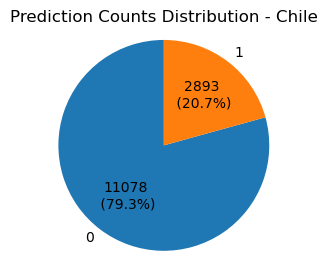

In [20]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return '{v:d}\n ({p:.1f}%)'.format(v=val, p=pct)
    return my_autopct

prediction_counts = earthquakes_chile_cutoff_copy['prediction'].value_counts()

# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(prediction_counts, labels=['0', '1'], autopct=make_autopct(prediction_counts), startangle=90)
plt.title('Prediction Counts Distribution - Chile')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


### SVC-HNN with 70-30 split

Train Data: 70% of the dataset <br>
 Test  Data: 30% of the dataset

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Average accuracy: 0.9889760447749911
Average precision/PPV: 0.9812607591493624
Average recall: 0.965103298253163
Average F1-score: 0.973014963673504
Average ROC AUC: 0.980159096706668
Average R2 Score: 0.932882408198003
Average NPV: 0.990953480571491
Average Specificity: 0.995214895160173
Average Matthews Correlation Coefficient: 0.9662204284036479


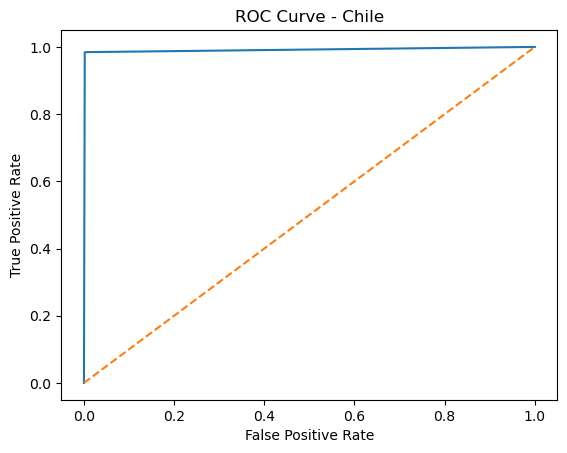

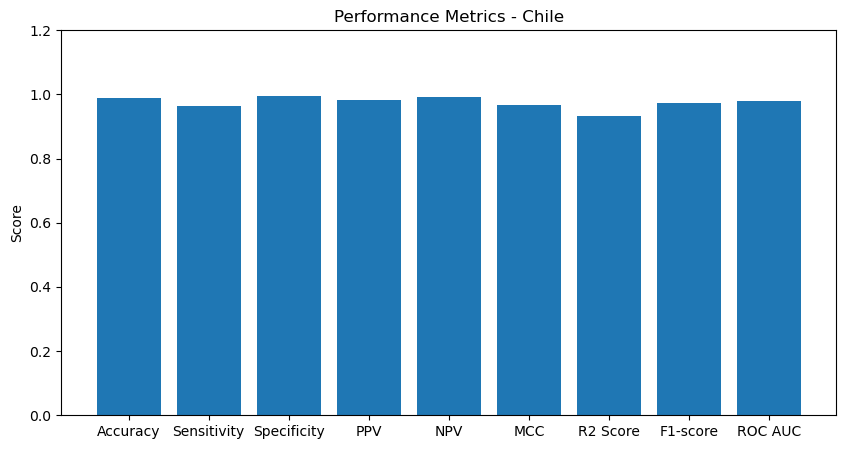

<Figure size 640x480 with 0 Axes>

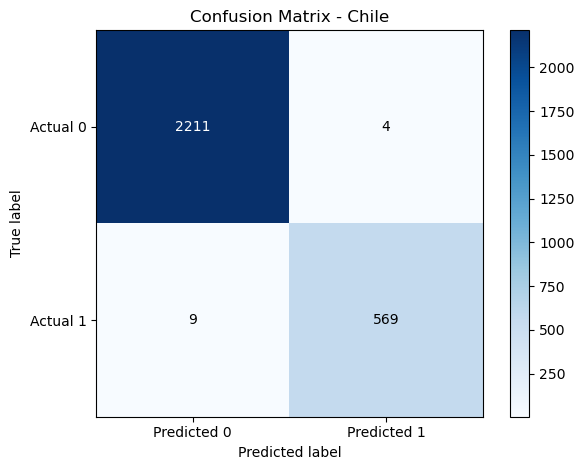

In [21]:
# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists for storing Performance Scores
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []

# Perform k-fold cross-validation
for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Append performance scores to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)

# Calculate the average of all the performance measures
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)

print("Average accuracy:", avg_accuracy)
print("Average precision/PPV:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
# print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix - Chile",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Chile")
plt.show()

# Plot performance measures
plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
plt.title("Performance Metrics - Chile")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


### SVC-HNN with time-based split

#### &emsp;Train Data: 01-01-1980 to 12-31-2018 || Test Data: 01-01-2019 to 02-28-2023

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9911230422923041
Average precision/PPV: 0.981122287075636
Average recall: 0.9761448864824807
Average F1-score: 0.9785090388615767
Average ROC AUC: 0.9855893936368855
Average R2 Score: 0.9459470470904099
Average NPV: 0.9937951805685774
Average Specificity: 0.9950339007912902
Average Matthews Correlation Coefficient: 0.9730142019291982


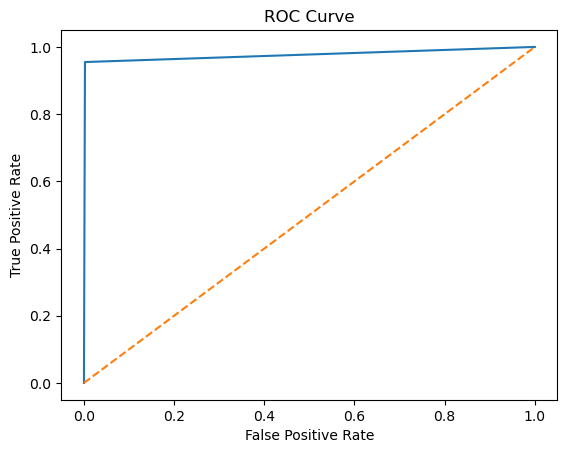

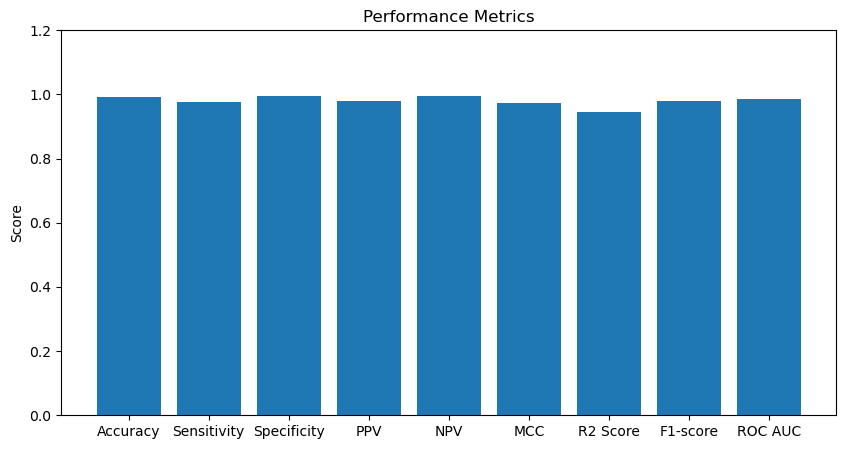

<Figure size 640x480 with 0 Axes>

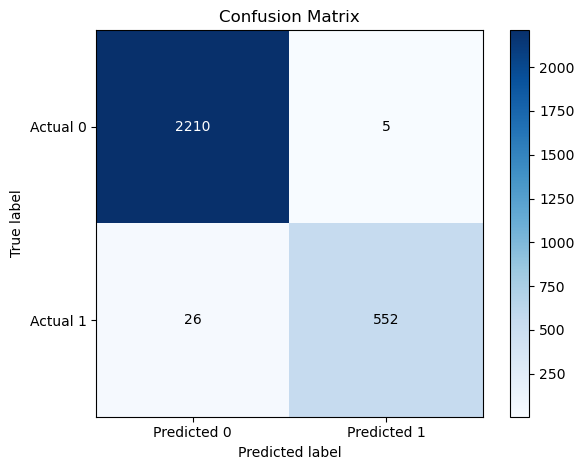

In [22]:
# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Filter data based on the date
split_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
df_filtered_copy['time'] = pd.to_datetime(df_filtered_copy['time']).dt.tz_localize(None)

train_data = df_filtered_copy[df_filtered_copy['time'] < split_date]
test_data = df_filtered_copy[df_filtered_copy['time'] >= split_date]

# Prepare data for the model
X_train = train_data.drop(['time', 'prediction'], axis=1).values
y_train = train_data['prediction'].values
X_test = test_data.drop(['time', 'prediction'], axis=1).values
y_test = test_data['prediction'].values

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Append performance scores to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)

# Calculate the average of all the performance measures
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)

print("Average accuracy:", avg_accuracy)
print("Average precision/PPV:", avg_precision)
print("Average recall:", avg_recall)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)
print("Average R2 Score:", avg_r2_score)
print("Average NPV:", avg_npv)
# print("Average PPV:", avg_ppv)
print("Average Specificity:", avg_specificity)
print("Average Matthews Correlation Coefficient:", avg_mcc)

def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
plt.title("Performance Metrics")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


### Handling Overfitting/Underfitting

<p>It is evident from the prediction counts Pie Chart that the dataset is significantly imbalanced. One class has significantly more instances than the other(s). This imbalance can lead to biased models because they will often simply predict the majority class, resulting in poor performance on the minority class. Hence, Synthetic Minority Over-sampling Technique (SMOTE) is used in collaboration with Stratified k-fold cross-validation to handle this challenge.</p>

### SVC-HNN || 70-30 || SMOTE

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: maximum iterations reached --> 100
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9854679392006963
Average Sensitivity: 0.9958537270440025
Average Specificity: 0.9827542763077475
Average NPV: 0.9989005941933782
Average Matthews Correlation Coefficient: 0.9581570240579435
Average R2 Score: 0.9115224478319931
Average precision/PPV: 0.9394382780705819
Average F1-score: 0.966410078728542
Average ROC AUC: 0.9893040016758752


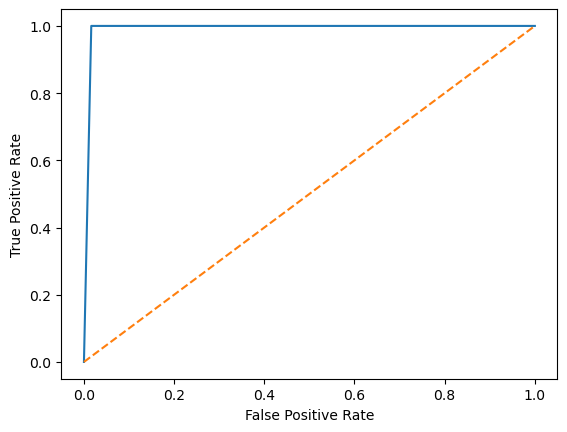

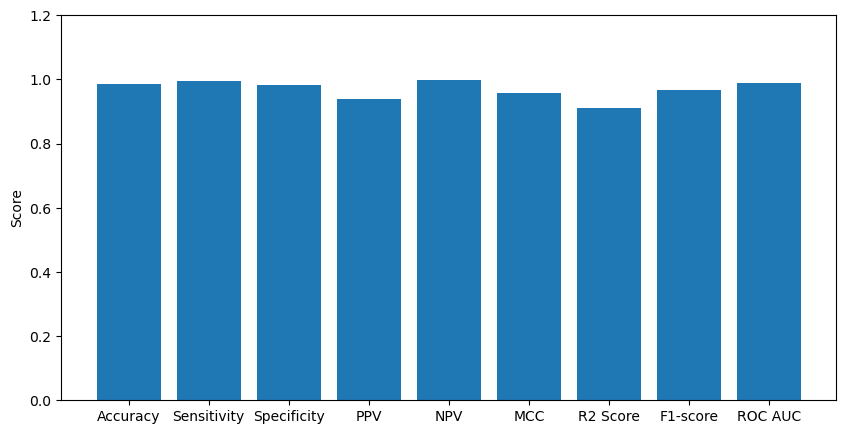

<Figure size 640x480 with 0 Axes>

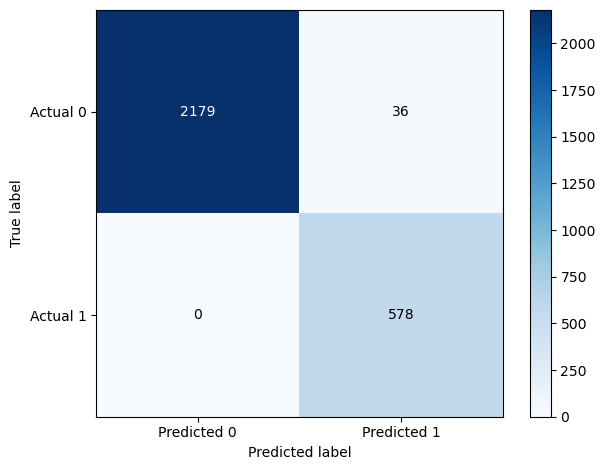

In [23]:
# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)

# Prepare data for the model
X = df_filtered_copy.drop(['time', 'prediction'], axis=1).values
y = df_filtered_copy['prediction'].values

# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []

for train_index, test_index in cv.split(X, y):
    
    cv_step = 0 # A counter variable to print at the end after each Cross Validation
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Apply SMOTE to balance the classes
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Append performance scores to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)

    

# Calculate the average of all the performance measures
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)

print("Average accuracy:", avg_accuracy)
print("Average Sensitivity:", avg_recall)
print("Average Specificity:", avg_specificity)
# print("Average PPV:", avg_ppv)
print("Average NPV:", avg_npv)
print("Average Matthews Correlation Coefficient:", avg_mcc)
print("Average R2 Score:", avg_r2_score)
print("Average precision/PPV:", avg_precision)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)


def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
#            title="Confusion Matrix - Chile (using SMOTE)",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC Curve - Chile (using SMOTE)")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
# plt.title("Performance Metrics - Chile (using SMOTE)")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


### SVC-HNN || time-based || SMOTE

Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average accuracy: 0.9892617831520205
Average Sensitivity: 0.9716555808547132
Average Specificity: 0.9938606155927342
Average NPV: 0.9926289203406633
Average Matthews Correlation Coefficient: 0.9674183184214102
Average R2 Score: 0.9346026194266901
Average precision/PPV: 0.9768023022974883
Average F1-score: 0.9740272937907969
Average ROC AUC: 0.9827580982237236


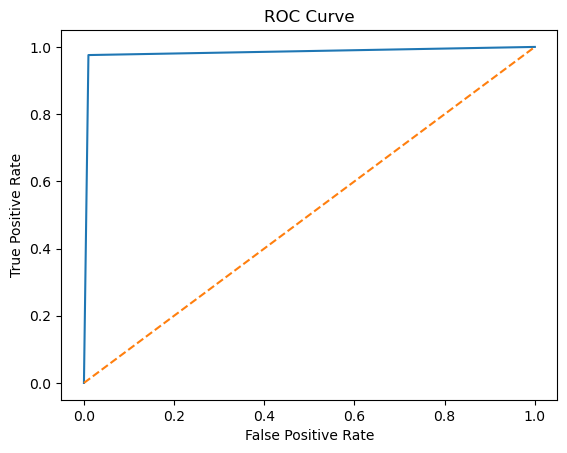

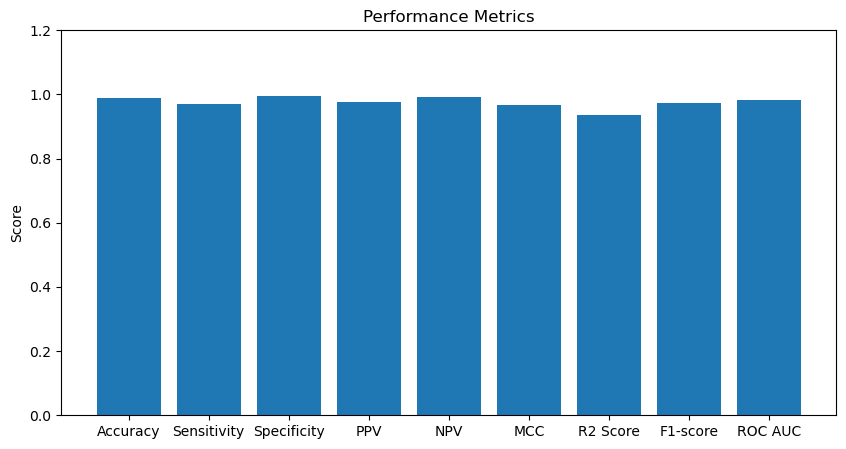

<Figure size 640x480 with 0 Axes>

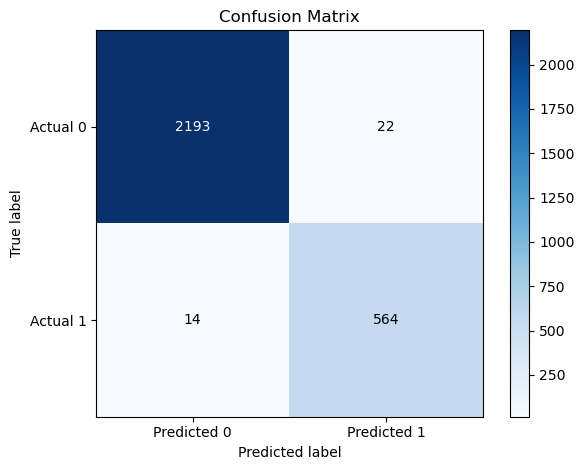

In [24]:
# Create a new DataFrame to avoid modifying the original
df_filtered_copy = df_filtered.copy()

# Add a 'prediction' column to the DataFrame
df_filtered_copy['prediction'] = (df_filtered_copy['mag'] >= 5.0).astype(int)

# Handle missing values by removing rows
# df_filtered_copy = df_filtered.dropna()

# Filter data based on the date
split_date = datetime.strptime('2019-01-01', '%Y-%m-%d')
df_filtered_copy['time'] = pd.to_datetime(df_filtered_copy['time']).dt.tz_localize(None)

train_data = df_filtered_copy[df_filtered_copy['time'] < split_date]
test_data = df_filtered_copy[df_filtered_copy['time'] >= split_date]

# Prepare data for the model
X_test = test_data.drop(['time', 'prediction'], axis=1).values
y_test = test_data['prediction'].values
X_train = train_data.drop(['time', 'prediction'], axis=1).values
y_train = train_data['prediction'].values


# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the SVC model
svc = SVC(kernel='rbf')
svc.fit(X_train_scaled, y_train)

# Get the SVC predictions
y_train_svc = svc.predict(X_train_scaled)
y_test_svc = svc.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

# Define layer_sizes and bounds for EPSO
input_size = X_train_hnn.shape[1]
hidden_size = int(input_size * 0.5)
layer_sizes = [hidden_size, hidden_size, 1]
bounds = (-1, 1)

# Train HNN with EPSO
ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

# Get the HNN predictions
y_test_pred = predict_ann(X_test_hnn, ann_weights)


# Initialize k-fold cross-validation
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []
r2_score_list = []
npv_list = []
ppv_list = []
specificity_list = []
mcc_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVC model
    svc = SVC(kernel='rbf', probability=True)
    svc.fit(X_train_scaled, y_train)

    # Get the SVC predictions
    y_train_svc = svc.predict(X_train_scaled)
    y_test_svc = svc.predict(X_test_scaled)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, y_train_svc))
    X_test_hnn = np.column_stack((X_test_scaled, y_test_svc))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Calculate R2 Score
    r2 = r2_score(y_test, y_test_pred)
    r2_score_list.append(r2)

    # Compute confusion matrix elements
    cm = confusion_matrix(y_test, y_test_pred)
    TN, FP, FN, TP = cm.ravel()

    # Calculate NPV and specificity
    npv = TN / (TN + FN)
    ppv = TP / (TP + FP)
    specificity = TN / (TN + FP)

    # Calculate MCC and log loss
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    roc_auc = roc_auc_score(y_test, y_test_pred)
    mcc = matthews_corrcoef(y_test, y_test_pred)

    # Append performance scores to the corresponding lists
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)
    npv_list.append(npv)
    ppv_list.append(ppv)
    specificity_list.append(specificity)
    mcc_list.append(mcc)

# Calculate the average of all the performance measures
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)
avg_roc_auc = np.mean(roc_auc_list)
avg_r2_score = np.mean(r2_score_list)
avg_npv = np.mean(npv_list)
avg_ppv = np.mean(ppv_list)
avg_specificity = np.mean(specificity_list)
avg_mcc = np.mean(mcc_list)

print("Average accuracy:", avg_accuracy)
print("Average Sensitivity:", avg_recall)
print("Average Specificity:", avg_specificity)
# print("Average PPV:", avg_ppv)
print("Average NPV:", avg_npv)
print("Average Matthews Correlation Coefficient:", avg_mcc)
print("Average R2 Score:", avg_r2_score)
print("Average precision/PPV:", avg_precision)
print("Average F1-score:", avg_f1)
print("Average ROC AUC:", avg_roc_auc)


def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=['Predicted 0', 'Predicted 1'],
           yticklabels=['Actual 0', 'Actual 1'],
           title="Confusion Matrix",
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations
    thresh = conf_matrix.max() / 2.0
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


# Plot the performance metrics
metrics = ['Accuracy', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'MCC', 'R2 Score', 'F1-score', 'ROC AUC']
metric_values = [avg_accuracy, avg_recall, avg_specificity, avg_ppv, avg_npv, avg_mcc, avg_r2_score, avg_f1, avg_roc_auc]

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(metrics, metric_values)
plt.title("Performance Metrics")
plt.ylabel("Score")
plt.ylim((0, 1.2))
plt.show()

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure()
plot_confusion_matrix(cm)
plt.show()


### SVR-HNN Regression Model

### SVR-HNN || 70-30 Split

Best parameters:  {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.014414382098302916
Average Mean Absolute Error: 0.07319423252166872
Average R2 Score: 0.9234206416511755
Average Root Mean Squared Error: 0.11531682777626909
Average Mean Absolute Percentage Error: 1.5329344256142647
Average Median Absolute Error: 0.05388537235661532
Average Explained Variance Score: 0.9234859503391009


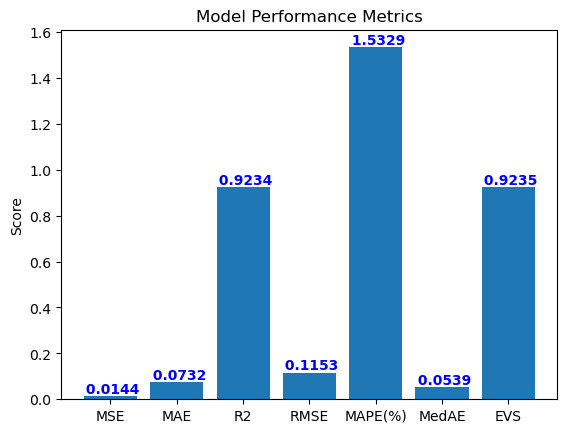

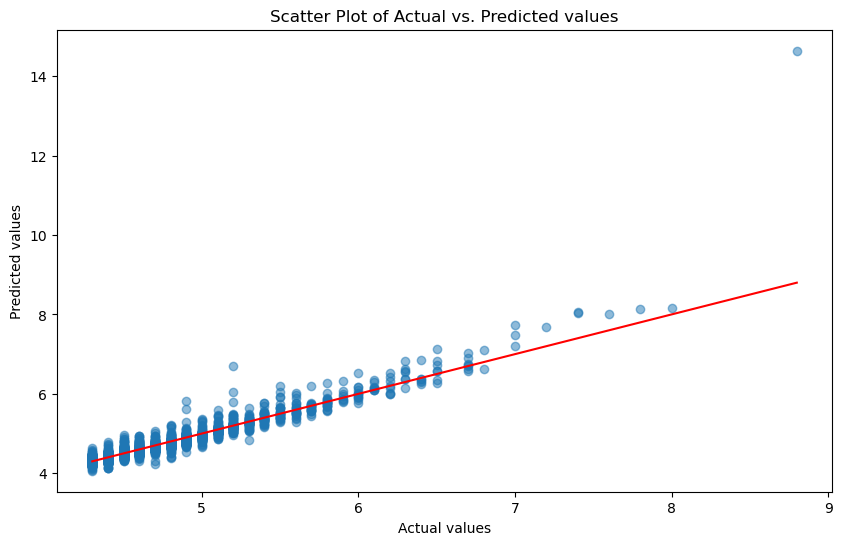

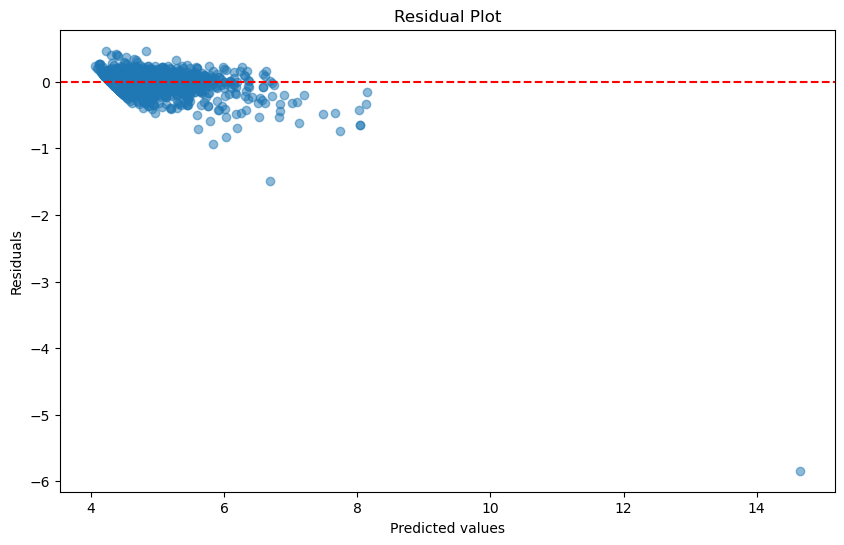

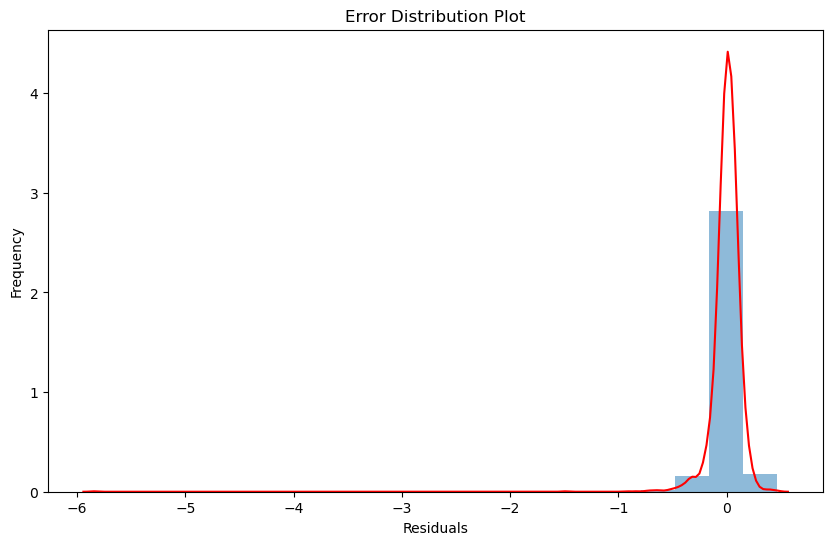

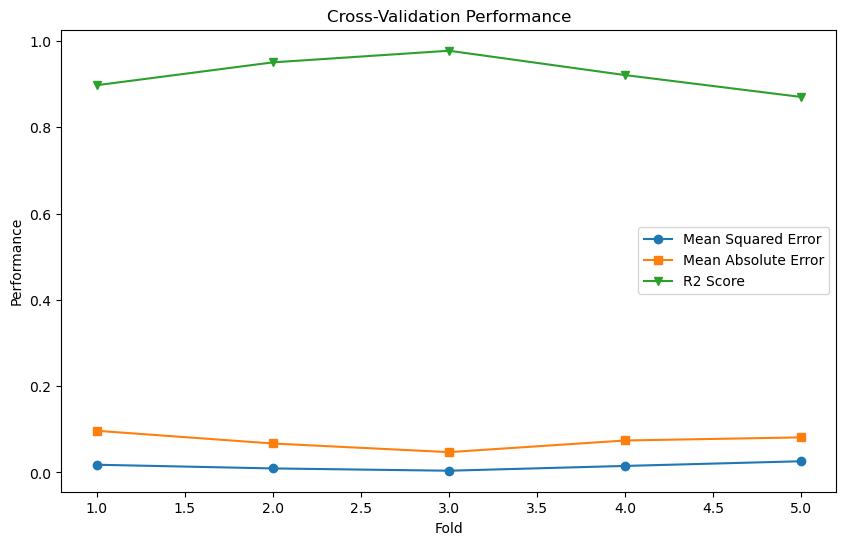

In [28]:
def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = leaky_relu(np.dot(layer_input, layer_weights.T))

        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
# Replace df_filtered with your actual DataFrame


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

X = df_filtered_copy.drop(['mag', 'time'], axis=1).values
y = df_filtered_copy['mag'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto']
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

best_params = svr_search.best_params_
print("Best parameters: ", best_params)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize the input features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVR model
    best_svr.fit(X_train_scaled, y_train)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_scaled)
    y_test_svr = best_svr.predict(X_test_scaled)


    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape = mean_absolute_percentage_error(y_test, y_test_pred)
    medae = median_absolute_error(y_test, y_test_pred)
    evs = explained_variance_score(y_test, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)

# Bar Plot
# Define the metrics
metrics = ['MSE', 'MAE', 'R2', 'RMSE', 'MAPE(%)', 'MedAE', 'EVS']
values = [avg_mse, avg_mae, avg_r2_score, avg_rmse, avg_mape, avg_medae, ev_score]

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(metrics, values)
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')

# Annotate the values
for i, v in enumerate(values):
    ax.text(i, v, f" {v:.4f}", ha='center', va='bottom', color='blue', fontweight='bold')

# Show the plot
plt.show()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs. Predicted values")
plt.show()

# Residual Plot
residuals = y_test - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Error Distribution Plot
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, density=True, alpha=0.5)

residuals = np.where(np.isnan(residuals), 0, residuals)  # replace np.nan with 0
sns.kdeplot(residuals, color='r')

plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Error Distribution Plot")
plt.show()

# Cross-validation Performance Plot
folds = np.arange(1, k + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, mse_list, marker='o', label="Mean Squared Error")
plt.plot(folds, mae_list, marker='s', label="Mean Absolute Error")
plt.plot(folds, r2_score_list, marker='v', label="R2 Score")
plt.xlabel("Fold")
plt.ylabel("Performance")
plt.title("Cross-Validation Performance")
plt.legend()
plt.show()



### SVR-HNN || time-based split

Best parameters:  {'C': 100, 'epsilon': 0.01, 'gamma': 0.01}
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Stopping search: Swarm best objective change less than 1e-08
Average Mean Squared Error: 0.006422904047384858
Average Mean Absolute Error: 0.05153051765332121
Average R2 Score: 0.966443335052556
Average Root Mean Squared Error: 0.07904399398552178
Average Mean Absolute Percentage Error: 1.0788057809833353
Average Median Absolute Error: 0.03860625941929694
Average Explained Variance Score: 0.966497544937323


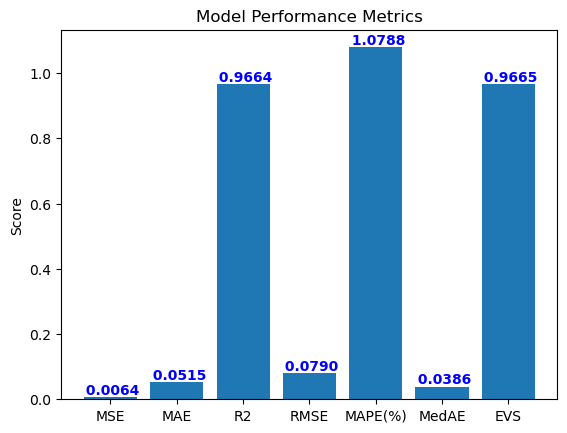

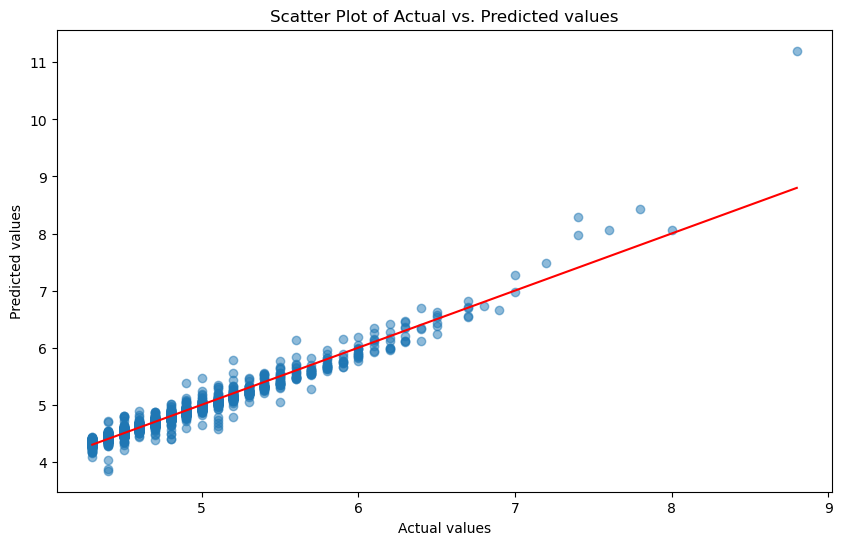

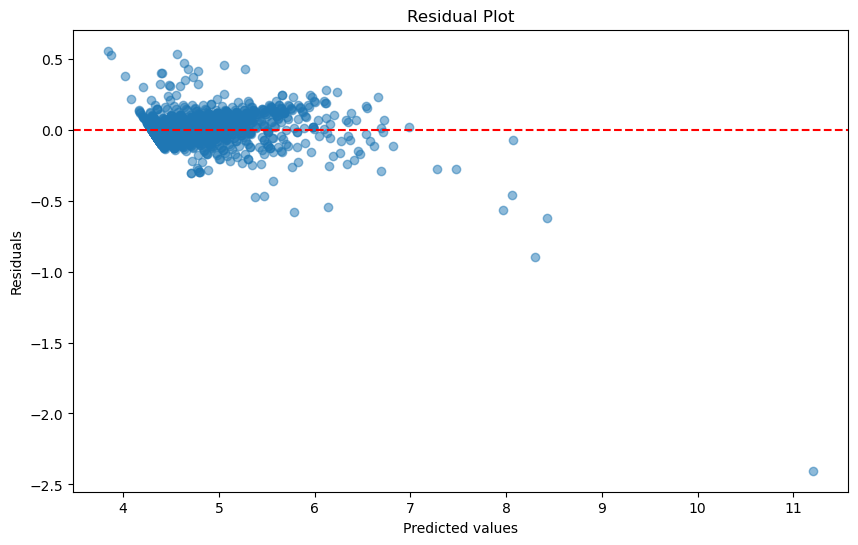

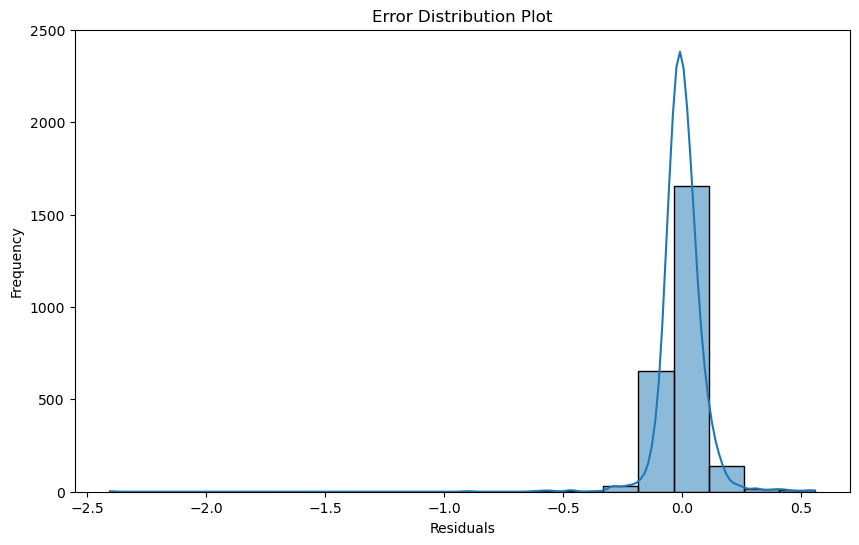

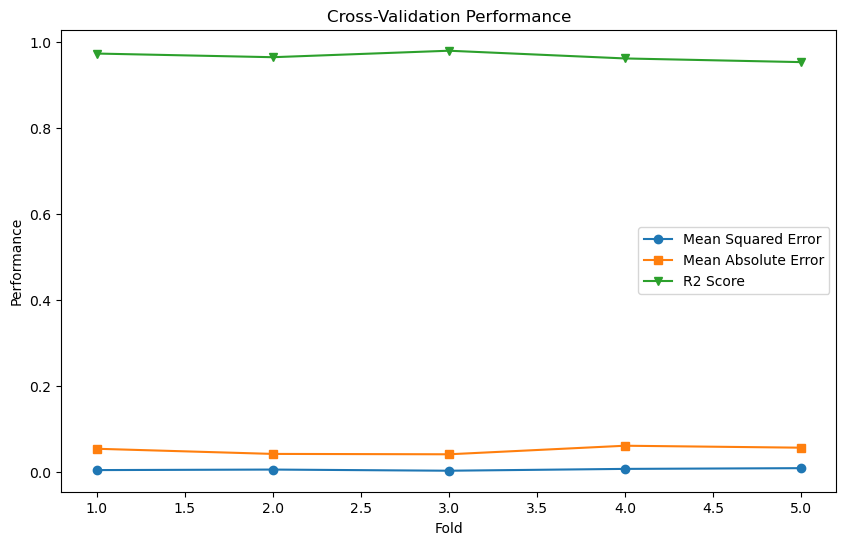

In [34]:
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def predict_ann(X, ann_weights):
    layer_input = X
    for i, layer_weight in enumerate(ann_weights[:-1]):
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
        layer_output = leaky_relu(np.dot(layer_input, layer_weight.T))
        layer_input = layer_output
    # For the last layer, use the identity function
    layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1)))) # Add the bias term
    layer_output = np.dot(layer_input, ann_weights[-1].T)
    return layer_output.squeeze()

# Assume pso function is already defined

def train_eps_ann(X_train, y_train, layer_sizes, bounds):
    num_weights = sum([(X_train.shape[1] + 1) * layer_size for layer_size in layer_sizes])
    lb, ub = bounds

    # Set up the objective function for the PSO
    obj_func = partial(eps_ann_mse, X_train=X_train, y_train=y_train, layer_sizes=layer_sizes)

    # Run the Enhanced Particle Swarm Optimization
    best_weights, best_mse = pso(obj_func, lb * np.ones(num_weights), ub * np.ones(num_weights), swarmsize=100, maxiter=300)

    # Reshape the best weights into the ANN weight matrices
    input_size = X_train.shape[1]
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (input_size + 1) * layer_size
        layer_weights = np.array(best_weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, input_size + 1)
        ann_weights.append(layer_weights)
        input_size = layer_size
        start = end

    return ann_weights

def eps_ann_mse(weights, X_train, y_train, layer_sizes):
    layer_input = X_train
    ann_weights = []
    start = 0
    for layer_size in layer_sizes:
        end = start + (layer_input.shape[1] + 1) * layer_size
        layer_weights = np.array(weights[start:end])
        layer_weights = layer_weights.reshape(layer_size, layer_input.shape[1] + 1)
        ann_weights.append(layer_weights)
        layer_input = np.column_stack((layer_input, np.ones((layer_input.shape[0], 1))))  # Add the bias term
        if len(ann_weights) == len(layer_sizes): # Last layer
            layer_output = np.dot(layer_input, layer_weights.T)
        else:
            layer_output = leaky_relu(np.dot(layer_input, layer_weights.T))
        layer_input = layer_output
        start = end

    # Calculate the mean squared error
    mse = np.mean((layer_output.squeeze() - y_train.squeeze()) ** 2)
    return mse

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


df_filtered_copy = df_filtered.copy()

# Handle missing values by removing rows
df_filtered_copy = df_filtered_copy.dropna()

# Split the data based on the 'time' feature
train_data = df_filtered_copy[df_filtered_copy['time'] < '2019-01-01']
test_data = df_filtered_copy[df_filtered_copy['time'] >= '2019-01-01']

# Prepare the training and testing sets
X_train = train_data.drop(['mag', 'time'], axis=1).values
y_train = train_data['mag'].values
X_test = test_data.drop(['mag', 'time'], axis=1).values
y_test = test_data['mag'].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# ---------------------------------------------------
# Define the parameter grid for SVR
svr_params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'gamma': [1, 0.1, 0.01, 0.001, 'scale', 'auto']
}

svr_search = GridSearchCV(SVR(kernel='rbf'), svr_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_search.fit(X_train_scaled, y_train)

best_params = svr_search.best_params_
print("Best parameters: ", best_params)

# Get the best SVR model
best_svr = svr_search.best_estimator_

# Get the SVR predictions
y_train_svr = best_svr.predict(X_train_scaled)
y_test_svr = best_svr.predict(X_test_scaled)

# Train the HNN using Enhanced Particle Swarm Optimization
input_size = X_train_scaled.shape[1]
hidden_size = int(input_size * 0.5)
X_train_hnn = np.column_stack((X_train_scaled, np.outer(y_train_svr, np.ones((1, hidden_size)))))
X_test_hnn = np.column_stack((X_test_scaled, np.outer(y_test_svr, np.ones((1, hidden_size)))))

# Define layer_sizes and bounds for EPSO
layer_sizes = [15, 10, 5, 1]  # Added an additional hidden layer
bounds = (-0.5, 0.5)

# Initialize k-fold cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
mse_list = []
mae_list = []
r2_score_list = []
rmse_list = []
mape_list = []
medae_list = []
evs_list = []

for train_index, test_index in cv.split(X_train_scaled, y_train):
    X_train_cv, X_test_cv = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

    # Train the SVR model
    best_svr.fit(X_train_cv, y_train_cv)

    # Get the SVR predictions
    y_train_svr = best_svr.predict(X_train_cv)
    y_test_svr = best_svr.predict(X_test_cv)

    # Train the HNN using Enhanced Particle Swarm Optimization
    X_train_hnn = np.column_stack((X_train_cv, np.outer(y_train_svr, np.ones((1, hidden_size)))))
    X_test_hnn = np.column_stack((X_test_cv, np.outer(y_test_svr, np.ones((1, hidden_size)))))

    # Train HNN with EPSO
    ann_weights = train_eps_ann(X_train_hnn, y_train_cv, layer_sizes, bounds)

    # Get the HNN predictions
    y_test_pred = predict_ann(X_test_hnn, ann_weights)

    # Compute evaluation metrics
    mse = mean_squared_error(y_test_cv, y_test_pred)
    mae = mean_absolute_error(y_test_cv, y_test_pred)
    r2 = r2_score(y_test_cv, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_cv, y_test_pred))
    mape = mean_absolute_percentage_error(y_test_cv, y_test_pred)
    medae = median_absolute_error(y_test_cv, y_test_pred)
    evs = explained_variance_score(y_test_cv, y_test_pred)

    # Append metrics to the corresponding lists
    mse_list.append(mse)
    mae_list.append(mae)
    r2_score_list.append(r2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    medae_list.append(medae)
    evs_list.append(evs)

# Calculate average evaluation metrics
avg_mse = np.mean(mse_list)
avg_mae = np.mean(mae_list)
avg_r2_score = np.mean(r2_score_list)
avg_rmse = np.mean(rmse_list)
avg_mape = np.mean(mape_list)
avg_medae = np.mean(medae_list)
ev_score = np.mean(evs_list)

print("Average Mean Squared Error:", avg_mse)
print("Average Mean Absolute Error:", avg_mae)
print("Average R2 Score:", avg_r2_score)
print("Average Root Mean Squared Error:", avg_rmse)
print("Average Mean Absolute Percentage Error:", avg_mape)
print("Average Median Absolute Error:", avg_medae)
print("Average Explained Variance Score:", ev_score)

# Bar Plot
# Define the metrics
metrics = ['MSE', 'MAE', 'R2', 'RMSE', 'MAPE(%)', 'MedAE', 'EVS']
values = [avg_mse, avg_mae, avg_r2_score, avg_rmse, avg_mape, avg_medae, ev_score]

# Create the bar plot
fig, ax = plt.subplots()
ax.bar(metrics, values)
ax.set_ylabel('Score')
ax.set_title('Model Performance Metrics')

# Annotate the values
for i, v in enumerate(values):
    ax.text(i, v, f" {v:.4f}", ha='center', va='bottom', color='blue', fontweight='bold')

# Show the plot
plt.show()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_cv, y_test_pred, alpha=0.5)
plt.plot([min(y_test_cv), max(y_test_cv)], [min(y_test_cv), max(y_test_cv)], color='red')
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Scatter Plot of Actual vs. Predicted values")
plt.show()

# Residual Plot
residuals = y_test_cv - y_test_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Error Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=20)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Error Distribution Plot")
plt.show()

# Cross-validation Performance Plot
folds = np.arange(1, k + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, mse_list, marker='o', label="Mean Squared Error")
plt.plot(folds, mae_list, marker='s', label="Mean Absolute Error")
plt.plot(folds, r2_score_list, marker='v', label="R2 Score")
plt.xlabel("Fold")
plt.ylabel("Performance")
plt.title("Cross-Validation Performance")
plt.legend()
plt.show()

